In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import pymc3 as pm
import skymotion
import skymotionModified
import skyfield
import corner
from scipy import optimize
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import arviz as az

##set random seed
rand_seed = np.random.randint(0,2**32-1)
## note jet angle is defined opposite to convention 
V404_jet_angle = 16 ## it is -16 in literature 
mc_iterations = 100
print("Random seed:", rand_seed)
%matplotlib inline

Random seed: 859554006


In [2]:
def jet_coordinates(alpha, delta, beta):
    """
    Applying a rotation matrix to transform ra and dec into parallel and perpendicular 
    to jet axis components.
    
    Parameters
    ----------
    alpha: Observation RA, an array, in degrees.
    
    delta: Observation Dec, an array, in degrees.

    beta: rotation angle (jet angle), in degrees.
    
    Returns
    -------    
    theta_perp, theta_para: rotated coordinates, perpendicular and parallel to the jet, respectively (in degrees).
    
    """
    beta_radian = np.radians(beta)
    theta_perp = alpha * np.cos(beta_radian) + delta * np.sin(beta_radian)
    theta_para = delta * np.cos(beta_radian) - alpha * np.sin(beta_radian)
    return theta_perp, theta_para

def mc_normal_sampler(mu, sigma):
    s = np.random.normal(mu, sigma, 10000)
    output = float(np.random.choice(s,1)[0])
    return output

def mc_trace_sampler(trace):
    output  = float(np.random.choice(trace,1)[0])
    return output

def perturbObsBasedOnErr(obs_alpha, obs_alpha_err, obs_delta, obs_delta_err):
    
    output_alpha = []
    output_delta = []
    
    for i in range(len(obs_alpha)):
        output_alpha.append(mc_normal_sampler(obs_alpha[i], obs_alpha_err[i]))
        output_delta.append(mc_normal_sampler(obs_delta[i], obs_delta_err[i]))
        
    return np.array(output_alpha), np.array(output_delta)

### Load data

In [3]:
#V404_Xband = Table.read('./V404Cygni_XBand_positions.txt', format='ascii',names=['RA', 'RA_err', 'DEC', 'DEC_err', 'MJD', 'MJD_err', "label"])
V404_Xband = Table.read('./V404CygniXBand.txt', format='ascii',names=['RA', 'RA_err', 'DEC', 'DEC_err', 'MJD', 'MJD_err', "label"])
V404_Cband = Table.read("./V404Cygni_CBand_globalfitV3.txt", format='ascii',names=['MJD', 'MJD_err', 'RA', 'RA_err', 'DEC', 'DEC_err', 'label'])


In [4]:
len(V404_Cband)

12

### Modify data to prefered data types

In [5]:
V404_timeX = V404_Xband['MJD'].data
V404_alphaX = SkyCoord(V404_Xband['RA'], V404_Xband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
V404_deltaX = SkyCoord(V404_Xband['RA'], V404_Xband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
V404_alpha_errX = V404_Xband['RA_err']/3600.0*15
V404_delta_errX = V404_Xband['DEC_err']/3600.0

V404_timeC = V404_Cband['MJD'].data
V404_alphaC = SkyCoord(V404_Cband['RA'], V404_Cband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
V404_deltaC = SkyCoord(V404_Cband['RA'], V404_Cband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
V404_alpha_errC = V404_Cband['RA_err']/3600.0*15
V404_delta_errC = V404_Cband['DEC_err']/3600.0



### Combine X-Band and C-band data 

In [6]:
V404_timeXC = np.concatenate((V404_timeX, V404_timeC))
V404_alphaXC = np.concatenate((V404_alphaX, V404_alphaC))
V404_deltaXC = np.concatenate((V404_deltaX, V404_deltaC))
V404_alpha_errXC = np.concatenate((V404_alpha_errX, V404_alpha_errC))
V404_delta_errXC = np.concatenate((V404_delta_errX, V404_delta_errC))
V404_maskXC = np.concatenate((np.full((len(V404_timeX)), False), np.full((len(V404_timeC)), True)))
V404_x_labels, V404_c_labels = [], []
for label in V404_Xband['label']:
    V404_x_labels.append("x-" + str(label))
for label in V404_Cband['label']:
    V404_c_labels.append("c-" + str(label))

V404_labelXC = np.concatenate(( V404_x_labels, V404_c_labels))




# V404_timeXC = np.copy(V404_timeX)
# V404_alphaXC = np.copy(V404_alphaX)
# V404_deltaXC = np.copy(V404_deltaX)
# V404_alpha_errXC = np.copy(V404_alpha_errX)
# V404_delta_errXC = np.copy(V404_delta_errX)
# V404_maskXC = np.copy(np.full((len(V404_timeX)), False))
# V404_x_labels, V404_c_labels = [], []
# for label in V404_Xband['label']:
#     V404_x_labels.append("x-" + str(label))

# V404_labelXC = np.copy( V404_x_labels)

### Perform 2D MCMC fitting

In [7]:

with pm.Model() as uniformed_model:
    
    ra_0_guess = V404_alphaXC.mean()
    dec_0_guess = V404_deltaXC.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
        
    ra_core_shift_prior = pm.Uniform('ra shift', lower=-1, upper=1) ## in deg (to prevent chain failing)
    dec_core_shift_prior = pm.Uniform('dec shift', lower=-1, upper=1) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior    
    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
                                             alpha = V404_alpha_coreshifted,
                                             delta = V404_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = V404_alpha_errXC * np.cos(V404_delta_coreshifted*np.pi/180), 
                           observed = V404_alpha_coreshifted * np.cos(V404_delta_coreshifted*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = V404_delta_errXC, 
                            observed = V404_delta_coreshifted)
    step_method = pm.NUTS()
    V404_trace_2D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [dec shift, ra shift, pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 68 seconds.
The acceptance probability does not match the target. It is 0.8809787134606615, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9899577913996797, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9867019600132829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9555816201459697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9434821116599291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.953450135336569, but should be close to 0.8. Try to increase the numb

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>],
       [<AxesSubplot:title={'center':'ra shift'}>,
        <AxesSubplot:title={'center':'ra shift'}>],
       [<AxesSubplot:title={'center':'dec shift'}>,
        <AxesSubplot:title={'center':'dec shift'}>]], dtype=object)

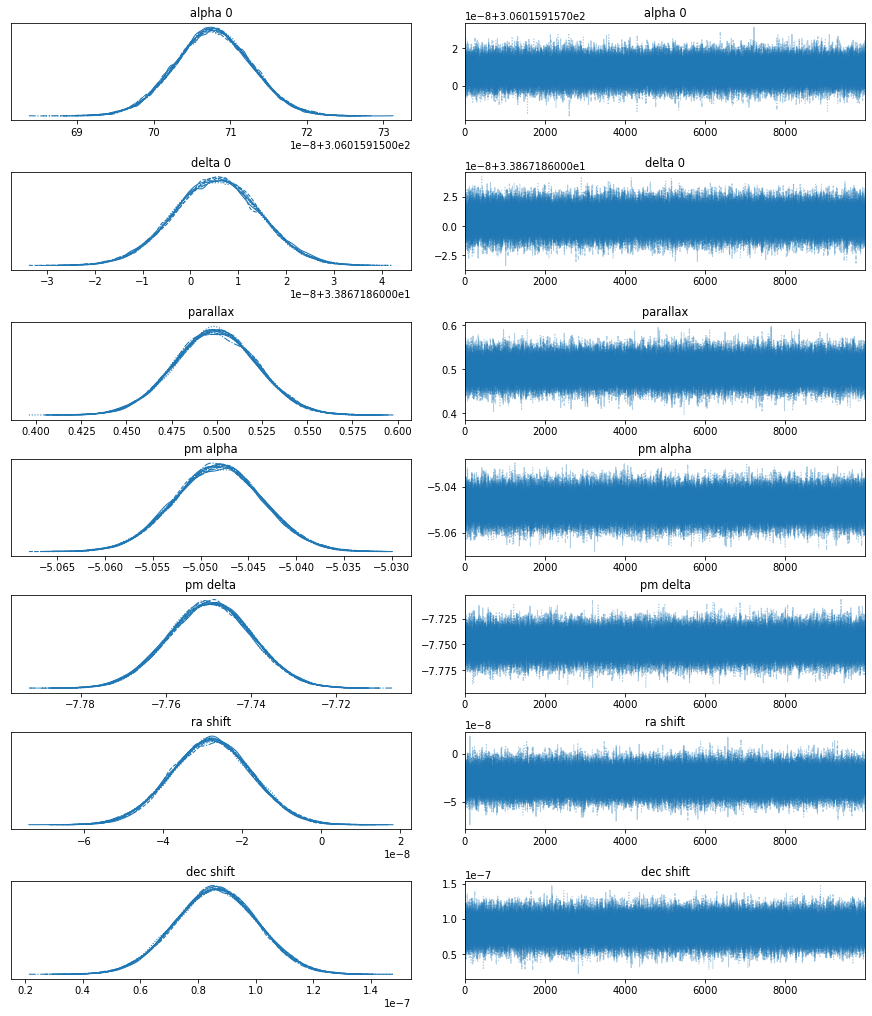

In [8]:
pm.traceplot(V404_trace_2D)

In [9]:
print("The determined core-shift for V404 offsets are")
print('ra  nu : {} mas'.format(np.median(V404_trace_2D['ra shift'])*3.6e6))
print('ra  sd : {} mas'.format(np.std(V404_trace_2D['ra shift'])*3.6e6))
print('dec nu : {} mas'.format(np.median(V404_trace_2D['dec shift'])*3.6e6))
print('dec sd : {} mas'.format(np.std(V404_trace_2D['dec shift'])*3.6e6))


The determined core-shift for V404 offsets are
ra  nu : -0.09999737458077362 mas
ra  sd : 0.03684827106014798 mas
dec nu : 0.31035788898847727 mas
dec sd : 0.05155447038792876 mas


### Update alpha and delta based on coreshift

In [10]:
V404_alphaXC_coreshifted = V404_alphaXC + V404_maskXC*np.median(V404_trace_2D['ra shift'])
V404_deltaXC_coreshifted = V404_deltaXC + V404_maskXC*np.median(V404_trace_2D['dec shift'])
## add errors in quadrature
V404_alpha_errXC_coreshifted = np.sqrt(V404_alpha_errXC**2 + np.std(V404_trace_2D['ra shift'])**2)
V404_delta_errXC_coreshifted = np.sqrt(V404_delta_errXC**2 + np.std(V404_trace_2D['dec shift'])**2)


### Perform 1D MCMC fitting

In [11]:
V404_theta_perp_t, V404_theta_para_t = jet_coordinates(V404_alphaXC_coreshifted * np.cos(np.radians(V404_deltaXC_coreshifted))\
                                             , V404_deltaXC_coreshifted, V404_jet_angle)
V404_theta_perp_er = np.sqrt((V404_alpha_errXC_coreshifted * np.cos(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errXC_coreshifted * np.sin(np.radians(V404_jet_angle)))**2)
V404_theta_para_er = np.sqrt((V404_alpha_errXC_coreshifted * np.sin(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errXC_coreshifted * np.cos(np.radians(V404_jet_angle)))**2)


with pm.Model() as projection_model:
    
    ra_0_guessXC = V404_alphaXC.mean()
    dec_0_guessXC = V404_deltaXC.mean()
    


    alpha_0_prior = pm.Normal('alpha 0',
                              mu=V404_trace_2D.get_values('alpha 0').mean(),
                              sd=V404_trace_2D.get_values('alpha 0').std())
    delta_0_prior = pm.Normal('delta 0',
                              mu=V404_trace_2D.get_values('delta 0').mean(),
                              sd=V404_trace_2D.get_values('delta 0').std())
    
    parallax_prior = pm.Normal('parallax',
                              mu=V404_trace_2D.get_values('parallax').mean(),
                              sd=V404_trace_2D.get_values('parallax').std())
    pm_alpha_prior = pm.Normal('pm alpha', 
                               mu=V404_trace_2D.get_values('pm alpha').mean(),
                               sd=V404_trace_2D.get_values('pm alpha').std())                      # In milliarcsec/yr
    
    pm_delta_prior = pm.Normal('pm delta', 
                               mu=V404_trace_2D.get_values('pm delta').mean(),
                               sd=V404_trace_2D.get_values('pm delta').std())                      # In milliarcsec/yr
    
#     ra_core_shift_prior = pm.Normal('ra shift',
#                                     mu=V404_trace_2D.get_values('ra shift').mean(),
#                                     sd=V404_trace_2D.get_values('ra shift').std()) ## in deg (to prevent chain failing)
#     dec_core_shift_prior = pm.Normal('dec shift', 
#                                      mu=V404_trace_2D.get_values('dec shift').mean(),
#                                      sd=V404_trace_2D.get_values('dec shift').std()) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior
    
    
    # Expected values for RA and Dec:
    # expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
    #                                          alpha = V404_alpha_coreshifted,
    #                                          delta = V404_delta_coreshifted,
    #                                          alpha_0 = alpha_0_prior,
    #                                          delta_0 = delta_0_prior,
    #                                          pm_alpha = pm_alpha_prior,
    #                                          pm_delta = pm_delta_prior,
    #                                          parallax = parallax_prior,
    #                                          orb_T_0 = orb_T_0_prior,
    #                                          orb_P = orb_P_prior,
    #                                          orb_e = orb_e_prior,
    #                                          orb_i = orb_i_prior,
    #                                          orb_omega = orb_omega_prior,
    #                                          orb_Omega = orb_Omega_prior,
    #                                          orb_a = orb_a_prior,
    #                                          binary_orbit = False)
    
    
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
                                             alpha = V404_alphaXC_coreshifted,
                                             delta = V404_deltaXC_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    
    expected_theta_perp, expected_theta_para = jet_coordinates(expected_ra, expected_dec, V404_jet_angle)
    
    # Observed quantities:  
    fitting_theta_perp = pm.Normal('theta_perp', mu = expected_theta_perp,
                                   sd = V404_theta_perp_er,
                                   observed = V404_theta_perp_t)

    step_method = pm.NUTS()
    V404_trace_1D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    

    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 28 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

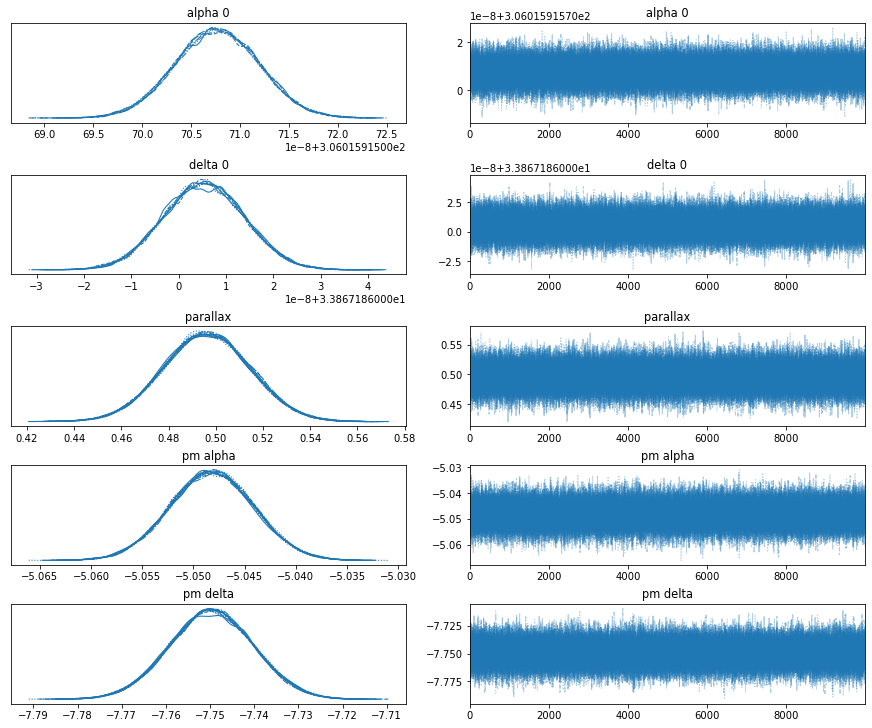

In [12]:
pm.traceplot(V404_trace_1D)

100%|██████████| 100/100 [00:01<00:00, 74.18it/s]
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


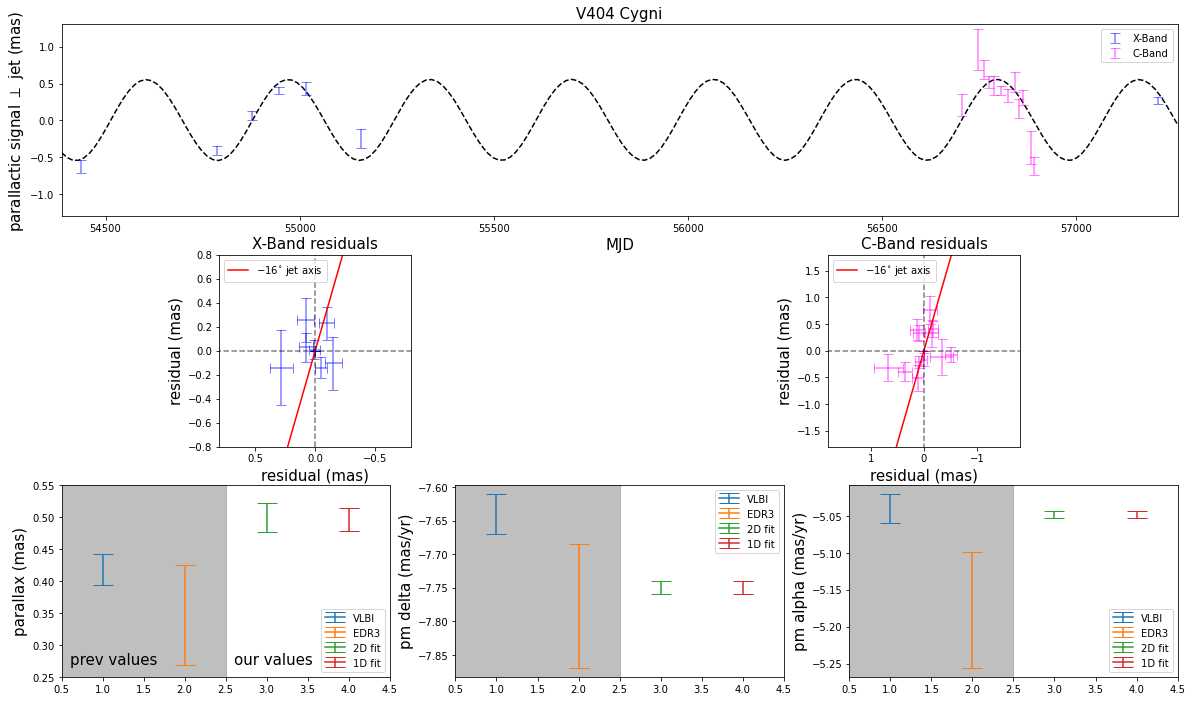

In [13]:

hfont = {'fontname':'Helvetica', 'size':15}

V404_c_band_mask = np.invert(np.copy(V404_maskXC))
V404_ra_residual_trace = []
V404_dec_residual_trace = []
V404_ra_parallax_signal_trace = []
V404_dec_parallax_signal_trace = []
V404_perp_trace = []
V404_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    V404_alpha, V404_delta = perturbObsBasedOnErr(V404_alphaXC_coreshifted, V404_alpha_errXC_coreshifted,\
                                                V404_deltaXC_coreshifted, V404_delta_errXC_coreshifted)
    
    V404_time = np.copy(V404_timeXC)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(V404_trace_1D['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(V404_trace_1D['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(V404_trace_1D['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(V404_trace_1D['alpha 0'])
    delta_0 = mc_trace_sampler(V404_trace_1D['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(V404_time, V404_alpha, V404_delta)
    ref_t = skymotion.t_0(V404_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(V404_delta)) + (pm_alpha_deg * (V404_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (V404_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    V404_ra_parallax_signal_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper)
    V404_dec_parallax_signal_trace.append(V404_delta - fit_dec_proper)
    V404_ra_residual_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra)
    V404_dec_residual_trace.append(V404_delta - fit_dec)
    
    ra = V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper
    dec = V404_delta - fit_dec_proper
    perp_t, para_t = jet_coordinates(ra, dec, V404_jet_angle)
    V404_perp_trace.append(perp_t)
    V404_para_trace.append(para_t)
    
    
    

time_array = np.linspace(np.min(V404_timeXC)-50, np.max(V404_timeXC)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(V404_trace_1D['alpha 0']), \
                                                 np.mean(V404_trace_1D['delta 0']) )

parallax_deg = np.mean(V404_trace_1D['parallax'])
theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, V404_jet_angle)
    
fig = plt.figure(figsize=(20,12))


plt.subplot(3,1,1)
plt.title('V404 Cygni',**hfont)
plt.plot(time_array, theta_perp_t, color="black", linestyle="dashed")
plt.xlim(min(time_array), max(time_array))



for x, y, z, label in zip(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6,np.std(V404_perp_trace, axis=0)*3.6e6, V404_labelXC):
    
    if label[0] == "x":
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='blue', alpha=0.5, label="X-Band")
    else:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='magenta', alpha=0.5, label="C-Band")

#plt.errorbar(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6, 
#             yerr=np.std(V404_perp_trace, axis=0)*3.6e6, fmt=" ", capsize=5)

plt.ylim(-1.3, 1.3)
plt.ylabel(r'parallactic signal $\perp$ jet (mas)',**hfont)
plt.xlabel("MJD",**hfont)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax1 = fig.add_subplot(323)
plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
             xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
             fmt=' ', capsize=5,color="blue", alpha=0.5)


x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(16 + 90))
plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
plt.title("X-Band residuals",**hfont)
plt.xlabel("residual (mas)",**hfont)
plt.ylabel("residual (mas)",**hfont)
plt.xlim(0.8, -0.8)
plt.ylim(-0.8, 0.8)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)



ax2 = fig.add_subplot(324)
plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             fmt=' ', capsize=5,color="magenta", alpha=0.5)


x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(16 + 90))
plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
plt.title("C-Band residuals",**hfont)
plt.xlabel("residual (mas)",**hfont)
plt.ylabel("residual (mas)",**hfont)
plt.xlim(1.8, -1.8)
plt.ylim(-1.8, 1.8)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)

ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax3 = plt.subplot(337)
plt.errorbar(1, 0.418, yerr=0.024, label="VLBI", capsize=10)
plt.errorbar(2, 0.3470492577849456, yerr=0.07828958332538605, label="EDR3", capsize=10)
plt.errorbar(3, np.mean(V404_trace_2D["parallax"]), yerr=np.std(V404_trace_2D["parallax"]), capsize=10, label="2D fit")
plt.errorbar(4, np.mean(V404_trace_1D["parallax"]), yerr=np.std(V404_trace_1D["parallax"]), capsize=10, label="1D fit")
ax3.axvspan(0, 2.5, ymin=0, ymax=1, alpha=0.5, color='grey')
plt.legend()
plt.ylim(0.25, 0.55)
plt.xlim(0.5, 4.5)
plt.ylabel("parallax (mas)",**hfont)
plt.text(0.6, 0.27, 'prev values', **hfont)
plt.text(2.6, 0.27, 'our values', **hfont)


ax4 = plt.subplot(338)
plt.errorbar(1, -7.64, yerr=0.03, label="VLBI", capsize=10)
plt.errorbar(2, -7.777607674200884, yerr= 0.09215836226940155, label="EDR3", capsize=10)
plt.errorbar(3, np.mean(V404_trace_2D["pm delta"]), yerr=np.std(V404_trace_2D["pm delta"]), capsize=10, label="2D fit")
plt.errorbar(4, np.mean(V404_trace_1D["pm delta"]), yerr=np.std(V404_trace_1D["pm delta"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm delta (mas/yr)",**hfont)
ax4.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
#plt.ylim(-6.55, -6.15)
plt.xlim(0.5, 4.5)




ax5 = plt.subplot(339)
plt.errorbar(1, -5.04, yerr=0.02, label="VLBI", capsize=10)
plt.errorbar(2, -5.177496222444664, yerr=0.07850257307291031	, label="EDR3", capsize=10)
plt.errorbar(3, np.mean(V404_trace_2D["pm alpha"]), yerr=np.std(V404_trace_2D["pm alpha"]), capsize=10, label="2D fit")
plt.errorbar(4, np.mean(V404_trace_1D["pm alpha"]), yerr=np.std(V404_trace_1D["pm alpha"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm alpha (mas/yr)",**hfont)
ax5.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
plt.xlim(0.5, 4.5)

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('V404results.png')

### Load check source data for V404 C-band observations

In [14]:
#load check source data
checkSourceC = Table.read("./c-bandJ2023-3153_globalfitV3.txt", format='ascii',names=['RA', 'RA_err', 'DEC', 'DEC_err', "label"])

## convert values to prefered data types
cs_alpha = SkyCoord(checkSourceC['RA'], checkSourceC['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
cs_delta = SkyCoord(checkSourceC['RA'], checkSourceC['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
cs_alpha_err = checkSourceC['RA_err']/3600.0*15
cs_delta_err = checkSourceC['DEC_err']/3600.0

cs_mean_alpha = np.median(cs_alpha)
cs_mean_delta = np.median(cs_delta)
print(cs_mean_alpha)
print(cs_mean_delta)


305.82923890916663
31.883973597361113


In [15]:
V404_Cband_ra_res_nu = []
V404_Cband_ra_res_std = []
V404_Cband_dec_res_nu = []
V404_Cband_dec_res_std = []

for ra_nu, ra_std, dec_nu, dec_std, mask in zip(np.median(V404_ra_residual_trace, axis=0)*3.6e6,
                                                np.std(V404_ra_residual_trace, axis=0)*3.6e6,
                                                np.median(V404_dec_residual_trace, axis=0)*3.6e6,
                                                np.std(V404_dec_residual_trace, axis=0)*3.6e6,
                                                V404_maskXC):
    if mask:
        V404_Cband_ra_res_nu.append(ra_nu)
        V404_Cband_ra_res_std.append(ra_std)
        V404_Cband_dec_res_nu.append(dec_nu)
        V404_Cband_dec_res_std.append(dec_std)



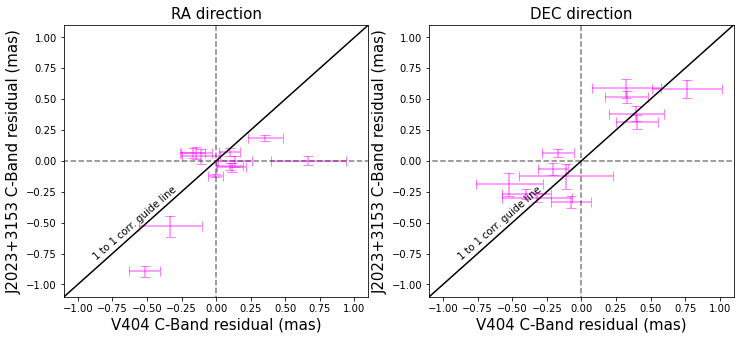

In [16]:
deg2mas = 3.6e6

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("RA direction",**hfont)
plt.xlabel("V404 C-Band residual (mas)",**hfont)
plt.ylabel("J2023+3153 C-Band residual (mas)",**hfont)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

#plt.errorbar(V404_Cband_ra_res_nu, (cs_alpha - cs_mean_alpha)*deg2mas*np.cos(np.radians(cs_delta)), \
#             xerr=V404_Cband_ra_res_std, yerr=cs_alpha_err*deg2mas*np.cos(np.radians(cs_delta)),\
#             fmt=' ', capsize=5, color='magenta', alpha=0.5)


plt.errorbar(V404_Cband_ra_res_nu, (cs_alpha - cs_mean_alpha)*deg2mas, \
             xerr=V404_Cband_ra_res_std, yerr=cs_alpha_err*deg2mas,\
             fmt=' ', capsize=5, color='magenta', alpha=0.5)


plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(-45 + 90))
plt.plot(x_array, y_array, color="black", label="1 to 1 corr. (guide only)")
plt.text(-0.8-0.1, -0.8, "1 to 1 corr. guide line", rotation=41)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)




plt.subplot(122)
plt.title("DEC direction",**hfont)
plt.xlabel("V404 C-Band residual (mas)",**hfont)
plt.ylabel("J2023+3153 C-Band residual (mas)",**hfont)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

plt.errorbar(V404_Cband_dec_res_nu, (cs_delta - cs_mean_delta)*deg2mas , \
             xerr=V404_Cband_dec_res_std, yerr=cs_delta_err*deg2mas,\
             fmt=' ', capsize=5, color='magenta', alpha=0.5)
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(-45 + 90))
plt.plot(x_array, y_array, color="black", label="1 to 1 corr. (guide only)")
plt.text(-0.8-0.1, -0.8, "1 to 1 corr. guide line", rotation=41)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.savefig('V404CBandResiduals.png')

### Re-do astrometry but with the check source residuals subtracted from V404

In [17]:
V404_alphaC_cs_corrected = V404_alphaC - (cs_alpha - cs_mean_alpha)
V404_deltaC_cs_corrected = V404_deltaC - (cs_delta - cs_mean_delta)
V404_alpha_errC_cs_corrected = V404_alpha_errC
V404_delta_errC_cs_corrected = V404_delta_errC

## Combine X and C band data

In [18]:
V404_timeXC = np.concatenate((V404_timeX, V404_timeC))
V404_alphaXC = np.concatenate((V404_alphaX,V404_alphaC_cs_corrected ))
V404_deltaXC = np.concatenate((V404_deltaX, V404_deltaC_cs_corrected))
V404_alpha_errXC = np.concatenate((V404_alpha_errX, V404_alpha_errC))
V404_delta_errXC = np.concatenate((V404_delta_errX, V404_delta_errC))
V404_maskXC = np.concatenate((np.full((len(V404_timeX)), False), np.full((len(V404_timeC)), True)))
V404_x_labels, V404_c_labels = [], []
for label in V404_Xband['label']:
    V404_x_labels.append("x-" + str(label))
for label in V404_Cband['label']:
    V404_c_labels.append("c-" + str(label))

V404_labelXC = np.concatenate(( V404_x_labels, V404_c_labels))


### Perform 2D MCMC

In [19]:
with pm.Model() as uniformed_model:
    
    ra_0_guess = V404_alphaXC.mean()
    dec_0_guess = V404_deltaXC.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
        
    ra_core_shift_prior = pm.Uniform('ra shift', lower=-1, upper=1) ## in deg (to prevent chain failing)
    dec_core_shift_prior = pm.Uniform('dec shift', lower=-1, upper=1) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior    
    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
                                             alpha = V404_alpha_coreshifted,
                                             delta = V404_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = V404_alpha_errXC * np.cos(V404_delta_coreshifted*np.pi/180), 
                           observed = V404_alpha_coreshifted * np.cos(V404_delta_coreshifted*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = V404_delta_errXC, 
                            observed = V404_delta_coreshifted)
    step_method = pm.NUTS()
    V404_trace_2DV2 = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [dec shift, ra shift, pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 110 seconds.
The acceptance probability does not match the target. It is 0.9148134645861515, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9246548598689144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9565764017667024, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9049741758282764, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887314842322519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9982471642126167, but should be close to 0.8. Try to increase the num

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>],
       [<AxesSubplot:title={'center':'ra shift'}>,
        <AxesSubplot:title={'center':'ra shift'}>],
       [<AxesSubplot:title={'center':'dec shift'}>,
        <AxesSubplot:title={'center':'dec shift'}>]], dtype=object)

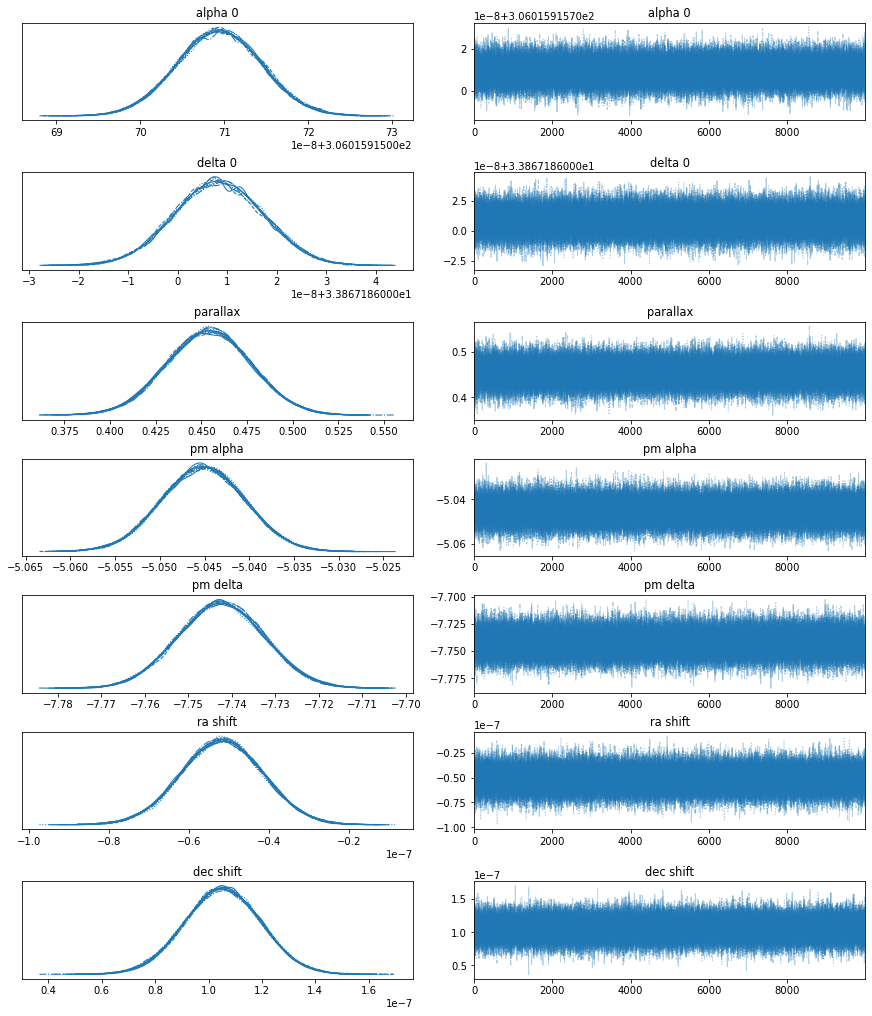

In [20]:
pm.traceplot(V404_trace_2DV2)

In [21]:
print("The determined core-shift for V404 offsets are")
print('ra  nu : {} mas'.format(np.median(V404_trace_2DV2['ra shift'])*3.6e6))
print('ra  sd : {} mas'.format(np.std(V404_trace_2DV2['ra shift'])*3.6e6))
print('dec nu : {} mas'.format(np.median(V404_trace_2DV2['dec shift'])*3.6e6))
print('dec sd : {} mas'.format(np.std(V404_trace_2DV2['dec shift'])*3.6e6))

The determined core-shift for V404 offsets are
ra  nu : -0.18610524161744024 mas
ra  sd : 0.036654056721198744 mas
dec nu : 0.3789898910699918 mas
dec sd : 0.05129684751717263 mas


## update alpha and delta based on core-shift

In [22]:
V404_alphaXC_coreshifted = V404_alphaXC + V404_maskXC*np.median(V404_trace_2DV2['ra shift'])
V404_deltaXC_coreshifted = V404_deltaXC + V404_maskXC*np.median(V404_trace_2DV2['dec shift'])
## add errors in quadrature
V404_alpha_errXC_coreshifted = np.sqrt(V404_alpha_errXC**2 + np.std(V404_trace_2DV2['ra shift'])**2)
V404_delta_errXC_coreshifted = np.sqrt(V404_delta_errXC**2 + np.std(V404_trace_2DV2['dec shift'])**2)


### 1D MCMC 

In [23]:
V404_theta_perp_t, V404_theta_para_t = jet_coordinates(V404_alphaXC_coreshifted * np.cos(np.radians(V404_deltaXC_coreshifted))\
                                             , V404_deltaXC_coreshifted, V404_jet_angle)
V404_theta_perp_er = np.sqrt((V404_alpha_errXC_coreshifted * np.cos(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errXC_coreshifted * np.sin(np.radians(V404_jet_angle)))**2)
V404_theta_para_er = np.sqrt((V404_alpha_errXC_coreshifted * np.sin(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errXC_coreshifted * np.cos(np.radians(V404_jet_angle)))**2)


with pm.Model() as projection_model:
    
    ra_0_guessXC = V404_alphaXC.mean()
    dec_0_guessXC = V404_deltaXC.mean()
    


    alpha_0_prior = pm.Normal('alpha 0',
                              mu=V404_trace_2DV2.get_values('alpha 0').mean(),
                              sd=V404_trace_2DV2.get_values('alpha 0').std())
    delta_0_prior = pm.Normal('delta 0',
                              mu=V404_trace_2DV2.get_values('delta 0').mean(),
                              sd=V404_trace_2DV2.get_values('delta 0').std())
    
    parallax_prior = pm.Normal('parallax',
                              mu=V404_trace_2DV2.get_values('parallax').mean(),
                              sd=V404_trace_2DV2.get_values('parallax').std())
    pm_alpha_prior = pm.Normal('pm alpha', 
                               mu=V404_trace_2DV2.get_values('pm alpha').mean(),
                               sd=V404_trace_2DV2.get_values('pm alpha').std())                      # In milliarcsec/yr
    
    pm_delta_prior = pm.Normal('pm delta', 
                               mu=V404_trace_2DV2.get_values('pm delta').mean(),
                               sd=V404_trace_2DV2.get_values('pm delta').std())                      # In milliarcsec/yr
    
#     ra_core_shift_prior = pm.Normal('ra shift',
#                                     mu=V404_trace_2D.get_values('ra shift').mean(),
#                                     sd=V404_trace_2D.get_values('ra shift').std()) ## in deg (to prevent chain failing)
#     dec_core_shift_prior = pm.Normal('dec shift', 
#                                      mu=V404_trace_2D.get_values('dec shift').mean(),
#                                      sd=V404_trace_2D.get_values('dec shift').std()) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior
    
    
    # Expected values for RA and Dec:
    # expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
    #                                          alpha = V404_alpha_coreshifted,
    #                                          delta = V404_delta_coreshifted,
    #                                          alpha_0 = alpha_0_prior,
    #                                          delta_0 = delta_0_prior,
    #                                          pm_alpha = pm_alpha_prior,
    #                                          pm_delta = pm_delta_prior,
    #                                          parallax = parallax_prior,
    #                                          orb_T_0 = orb_T_0_prior,
    #                                          orb_P = orb_P_prior,
    #                                          orb_e = orb_e_prior,
    #                                          orb_i = orb_i_prior,
    #                                          orb_omega = orb_omega_prior,
    #                                          orb_Omega = orb_Omega_prior,
    #                                          orb_a = orb_a_prior,
    #                                          binary_orbit = False)
    
    
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
                                             alpha = V404_alphaXC_coreshifted,
                                             delta = V404_deltaXC_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    
    expected_theta_perp, expected_theta_para = jet_coordinates(expected_ra, expected_dec, V404_jet_angle)
    
    # Observed quantities:  
    fitting_theta_perp = pm.Normal('theta_perp', mu = expected_theta_perp,
                                   sd = V404_theta_perp_er,
                                   observed = V404_theta_perp_t)

    step_method = pm.NUTS()
    V404_trace_1DV2 = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    

    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 28 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

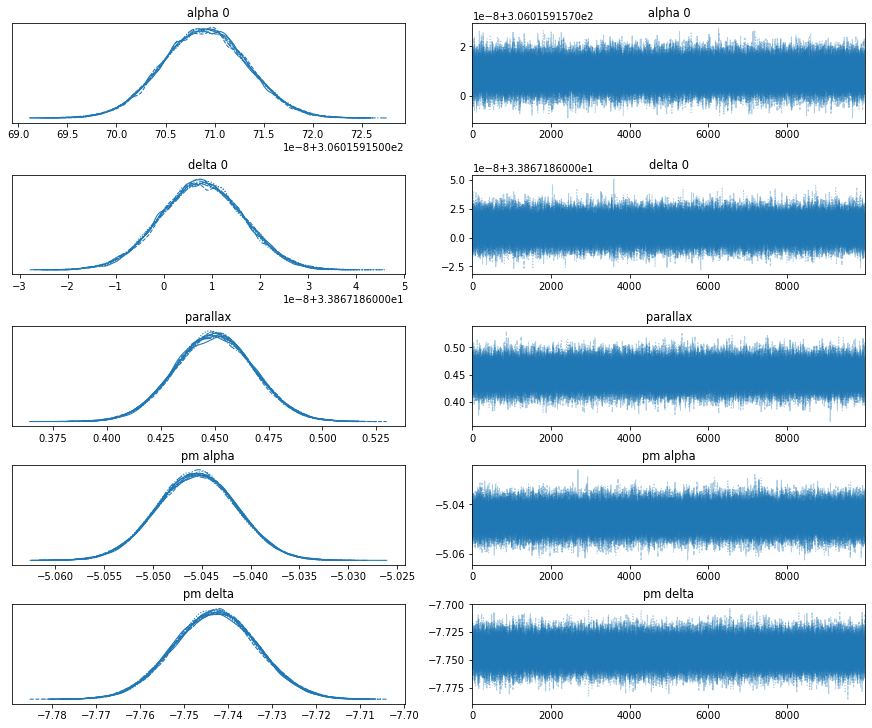

In [24]:
pm.traceplot(V404_trace_1DV2)

100%|██████████| 100/100 [00:01<00:00, 72.79it/s]
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


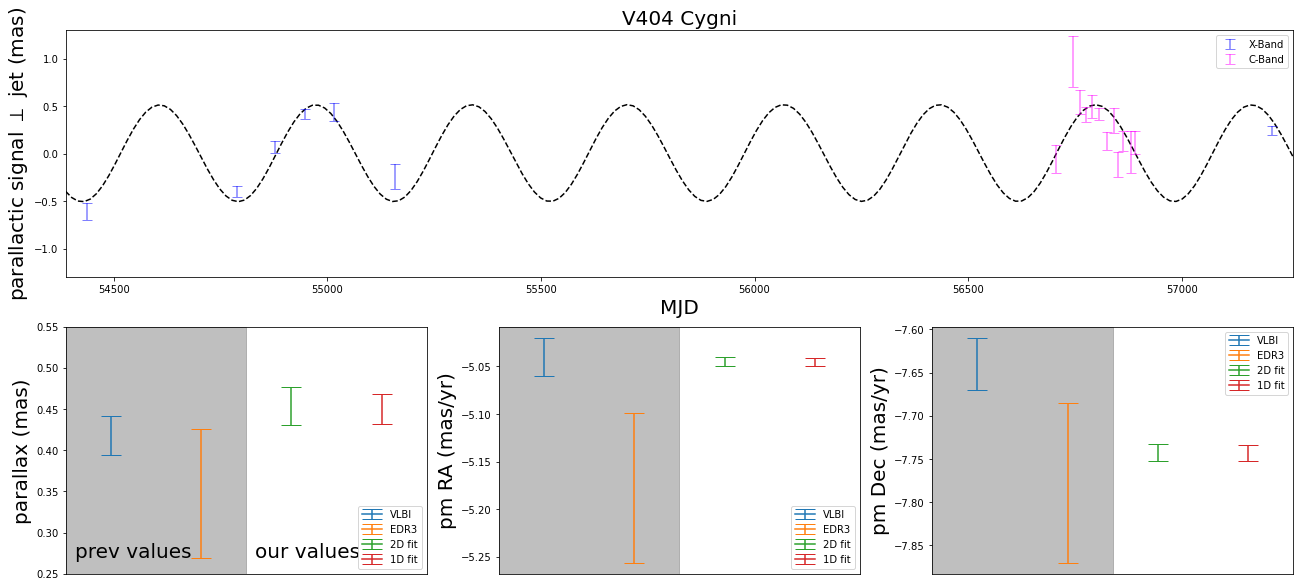

In [25]:
hfont = {'fontname':'Helvetica', 'size':20}

V404_c_band_mask = np.invert(np.copy(V404_maskXC))
V404_ra_residual_trace = []
V404_dec_residual_trace = []
V404_ra_parallax_signal_trace = []
V404_dec_parallax_signal_trace = []
V404_perp_trace = []
V404_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    V404_alpha, V404_delta = perturbObsBasedOnErr(V404_alphaXC_coreshifted, V404_alpha_errXC_coreshifted,\
                                                V404_deltaXC_coreshifted, V404_delta_errXC_coreshifted)
    
    V404_time = np.copy(V404_timeXC)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(V404_trace_1DV2['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(V404_trace_1DV2['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(V404_trace_1DV2['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(V404_trace_1DV2['alpha 0'])
    delta_0 = mc_trace_sampler(V404_trace_1DV2['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(V404_time, V404_alpha, V404_delta)
    ref_t = skymotion.t_0(V404_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(V404_delta)) + (pm_alpha_deg * (V404_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (V404_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    V404_ra_parallax_signal_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper)
    V404_dec_parallax_signal_trace.append(V404_delta - fit_dec_proper)
    V404_ra_residual_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra)
    V404_dec_residual_trace.append(V404_delta - fit_dec)
    
    ra = V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper
    dec = V404_delta - fit_dec_proper
    perp_t, para_t = jet_coordinates(ra, dec, V404_jet_angle)
    V404_perp_trace.append(perp_t)
    V404_para_trace.append(para_t)
    
    
    

time_array = np.linspace(np.min(V404_timeXC)-50, np.max(V404_timeXC)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(V404_trace_1DV2['alpha 0']), \
                                                 np.mean(V404_trace_1DV2['delta 0']) )

parallax_deg = np.mean(V404_trace_1DV2['parallax'])
theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, V404_jet_angle)
    
fig = plt.figure(figsize=(22,10))


plt.subplot(2,1,1)
plt.title('V404 Cygni',**hfont)
plt.plot(time_array, theta_perp_t, color="black", linestyle="dashed")
plt.xlim(min(time_array), max(time_array))



for x, y, z, label in zip(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6,np.std(V404_perp_trace, axis=0)*3.6e6, V404_labelXC):
    
    if label[0] == "x":
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='blue', alpha=0.5, label="X-Band")
    else:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='magenta', alpha=0.5, label="C-Band")

#plt.errorbar(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6, 
#             yerr=np.std(V404_perp_trace, axis=0)*3.6e6, fmt=" ", capsize=5)

plt.ylim(-1.3, 1.3)
plt.ylabel(r'parallactic signal $\perp$ jet (mas)',**hfont)
plt.xlabel("MJD",**hfont)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# ax1 = fig.add_subplot(323)
# plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
#              xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
#              fmt=' ', capsize=5,color="blue", alpha=0.5)


# x_array = np.linspace(-1.5, 1.5, 10)
# y_array = x_array*np.tan(np.radians(16 + 90))
# plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
# plt.title("X-Band residuals",**hfont)
# plt.xlabel("residual (mas)",**hfont)
# plt.ylabel("residual (mas)",**hfont)
# plt.xlim(0.8, -0.8)
# plt.ylim(-0.8, 0.8)
# plt.legend()
# plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
# plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)



# ax2 = fig.add_subplot(324)
# plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
#              xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
#              fmt=' ', capsize=5,color="magenta", alpha=0.5)


# x_array = np.linspace(-1.5, 1.5, 10)
# y_array = x_array*np.tan(np.radians(16 + 90))
# plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
# plt.title("C-Band residuals",**hfont)
# plt.xlabel("residual (mas)",**hfont)
# plt.ylabel("residual (mas)",**hfont)
# plt.xlim(1.8, -1.8)
# plt.ylim(-1.8, 1.8)
# plt.legend()
# plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
# plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)

# ax1.set_aspect('equal')
# ax2.set_aspect('equal')

ax3 = plt.subplot(234)
plt.errorbar(1, 0.418, yerr=0.024, label="VLBI", capsize=10)
plt.errorbar(2, 0.3470492577849456, yerr=0.07828958332538605, label="EDR3", capsize=10)
plt.errorbar(3, np.mean(V404_trace_2DV2["parallax"]), yerr=np.std(V404_trace_2DV2["parallax"]), capsize=10, label="2D fit")
plt.errorbar(4, np.mean(V404_trace_1DV2["parallax"]), yerr=np.std(V404_trace_1DV2["parallax"]), capsize=10, label="1D fit")
ax3.axvspan(0, 2.5, ymin=0, ymax=1, alpha=0.5, color='grey')
plt.legend()
plt.ylim(0.25, 0.55)
plt.xlim(0.5, 4.5)
plt.ylabel("parallax (mas)",**hfont)
plt.text(0.6, 0.27, 'prev values', **hfont)
plt.text(2.6, 0.27, 'our values', **hfont)
plt.xticks([]) 

ax4 = plt.subplot(236)
plt.errorbar(1, -7.64, yerr=0.03, label="VLBI", capsize=10)
plt.errorbar(2, -7.777607674200884, yerr= 0.09215836226940155, label="EDR3", capsize=10)
plt.errorbar(3, np.mean(V404_trace_2DV2["pm delta"]), yerr=np.std(V404_trace_2DV2["pm delta"]), capsize=10, label="2D fit")
plt.errorbar(4, np.mean(V404_trace_1DV2["pm delta"]), yerr=np.std(V404_trace_1DV2["pm delta"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm Dec (mas/yr)",**hfont)
ax4.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
#plt.ylim(-6.55, -6.15)
plt.xlim(0.5, 4.5)
plt.xticks([]) 



ax5 = plt.subplot(235)
plt.errorbar(1, -5.04, yerr=0.02, label="VLBI", capsize=10)
plt.errorbar(2, -5.177496222444664, yerr=0.07850257307291031	, label="EDR3", capsize=10)
plt.errorbar(3, np.mean(V404_trace_2DV2["pm alpha"]), yerr=np.std(V404_trace_2DV2["pm alpha"]), capsize=10, label="2D fit")
plt.errorbar(4, np.mean(V404_trace_1DV2["pm alpha"]), yerr=np.std(V404_trace_1DV2["pm alpha"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm RA (mas/yr)",**hfont)
ax5.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
plt.xlim(0.5, 4.5)
plt.xticks([]) 

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


### MCMC 2D fit just using X-Band data

In [26]:
with pm.Model() as uniformed_model:
    
    ra_0_guess = V404_alphaX.mean()
    dec_0_guess = V404_deltaX.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
        
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior    
    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeX,
                                             alpha = V404_alphaX,
                                             delta = V404_deltaX,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = V404_alpha_errX * np.cos(V404_deltaX*np.pi/180), 
                           observed = V404_alphaX * np.cos(V404_deltaX*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = V404_delta_errX, 
                            observed = V404_deltaX)
    step_method = pm.NUTS()
    V404_trace_2DX = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 30 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

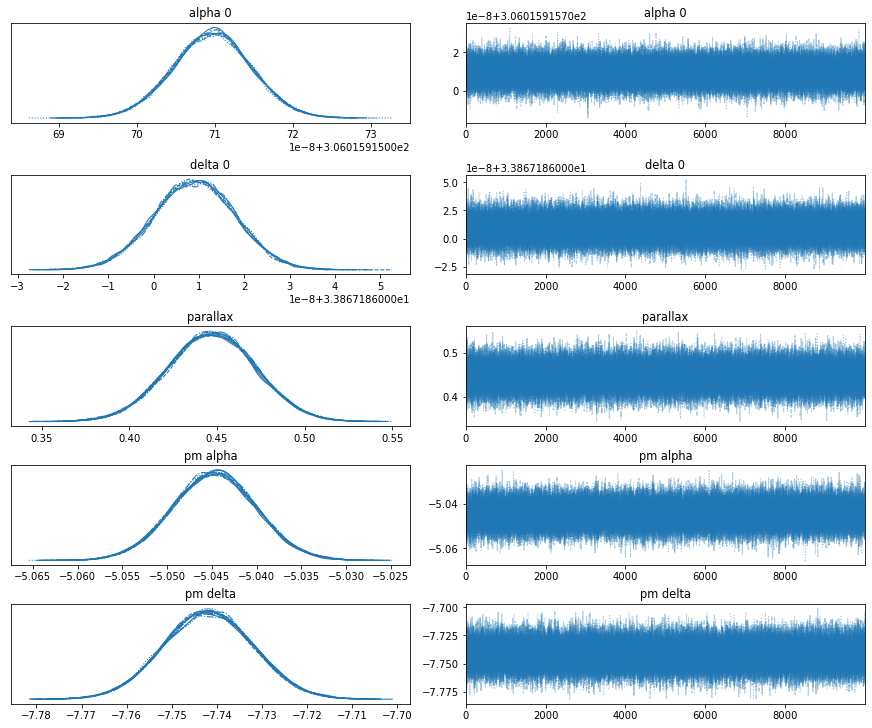

In [27]:
pm.traceplot(V404_trace_2DX)

### 1D MCMC just using X-band

In [28]:
V404_theta_perp_t, V404_theta_para_t = jet_coordinates(V404_alphaX * np.cos(np.radians(V404_deltaX))\
                                             , V404_deltaX, V404_jet_angle)
V404_theta_perp_er = np.sqrt((V404_alpha_errX * np.cos(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errX* np.sin(np.radians(V404_jet_angle)))**2)
V404_theta_para_er = np.sqrt((V404_alpha_errX * np.sin(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errX * np.cos(np.radians(V404_jet_angle)))**2)


with pm.Model() as projection_model:
    
    ra_0_guessXC = V404_alphaX.mean()
    dec_0_guessXC = V404_deltaX.mean()
    

    alpha_0_prior = pm.Normal('alpha 0',
                              mu=V404_trace_2DX.get_values('alpha 0').mean(),
                              sd=V404_trace_2DX.get_values('alpha 0').std())
    delta_0_prior = pm.Normal('delta 0',
                              mu=V404_trace_2DX.get_values('delta 0').mean(),
                              sd=V404_trace_2DX.get_values('delta 0').std())
    
    parallax_prior = pm.Normal('parallax',
                              mu=V404_trace_2DX.get_values('parallax').mean(),
                              sd=V404_trace_2DX.get_values('parallax').std())
    pm_alpha_prior = pm.Normal('pm alpha', 
                               mu=V404_trace_2DX.get_values('pm alpha').mean(),
                               sd=V404_trace_2DX.get_values('pm alpha').std())                      # In milliarcsec/yr
    
    pm_delta_prior = pm.Normal('pm delta', 
                               mu=V404_trace_2DX.get_values('pm delta').mean(),
                               sd=V404_trace_2DX.get_values('pm delta').std())                      # In milliarcsec/yr
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior
    
    
    # Expected values for RA and Dec:
    # expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
    #                                          alpha = V404_alpha_coreshifted,
    #                                          delta = V404_delta_coreshifted,
    #                                          alpha_0 = alpha_0_prior,
    #                                          delta_0 = delta_0_prior,
    #                                          pm_alpha = pm_alpha_prior,
    #                                          pm_delta = pm_delta_prior,
    #                                          parallax = parallax_prior,
    #                                          orb_T_0 = orb_T_0_prior,
    #                                          orb_P = orb_P_prior,
    #                                          orb_e = orb_e_prior,
    #                                          orb_i = orb_i_prior,
    #                                          orb_omega = orb_omega_prior,
    #                                          orb_Omega = orb_Omega_prior,
    #                                          orb_a = orb_a_prior,
    #                                          binary_orbit = False)
    
    
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeX,
                                             alpha = V404_alphaX,
                                             delta = V404_deltaX,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    
    expected_theta_perp, expected_theta_para = jet_coordinates(expected_ra, expected_dec, V404_jet_angle)
    
    # Observed quantities:  
    fitting_theta_perp = pm.Normal('theta_perp', mu = expected_theta_perp,
                                   sd = V404_theta_perp_er,
                                   observed = V404_theta_perp_t)

    step_method = pm.NUTS()
    V404_trace_1DX = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    

    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:95: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 28 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

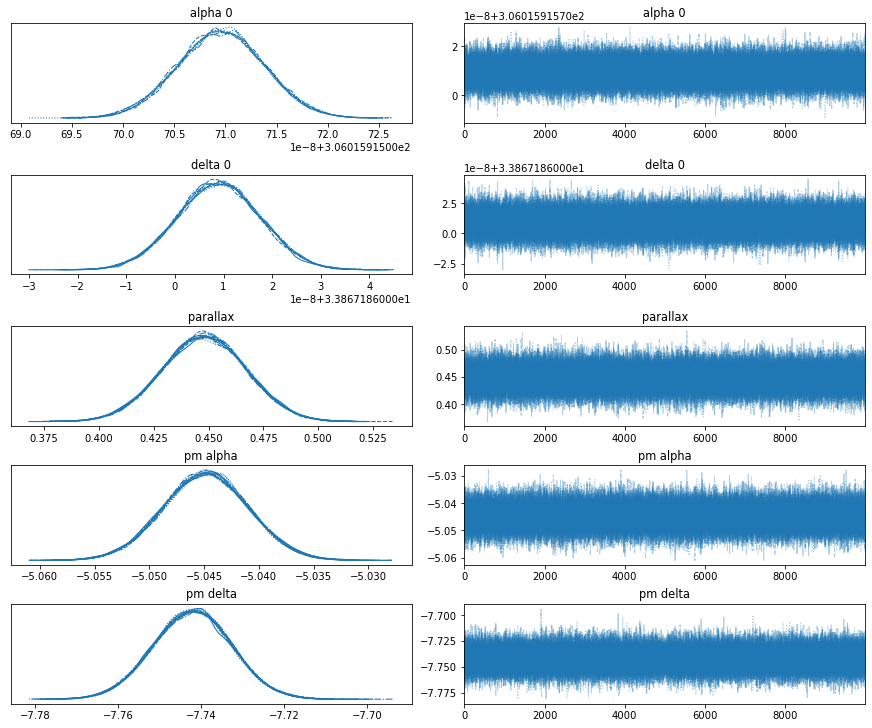

In [29]:
pm.traceplot(V404_trace_1DX)

### plot for paper (bug...have to run prev mcmc cells before running below)

100%|██████████| 100/100 [00:01<00:00, 68.44it/s]
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


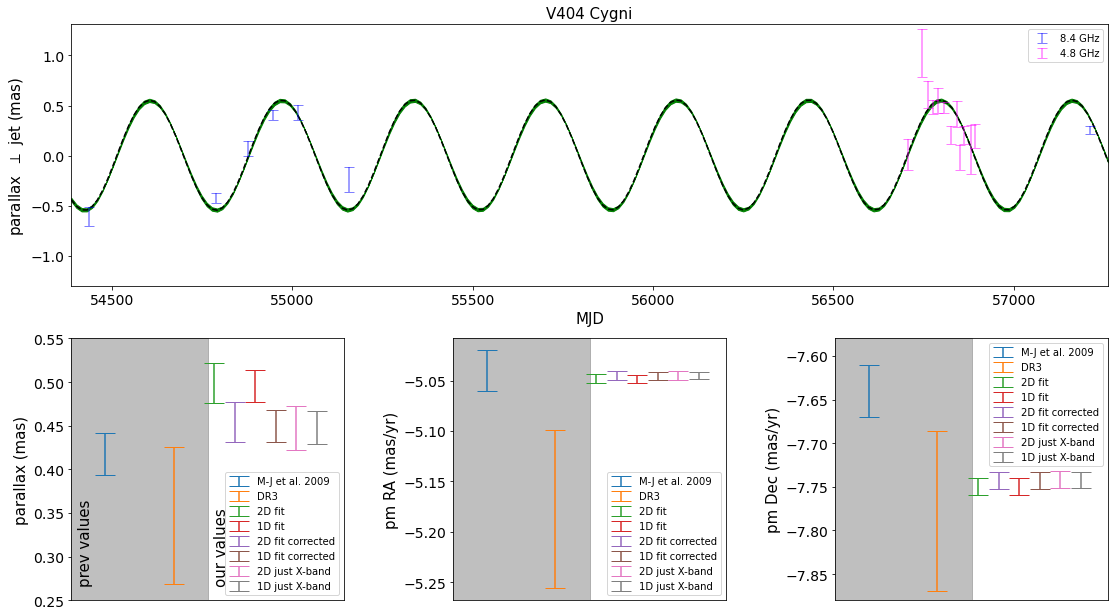

In [47]:
hfont = {'fontname':'Helvetica', 'size':15}


V404_alphaXC_coreshifted = V404_alphaXC + V404_maskXC*np.median(V404_trace_2D['ra shift'])
V404_deltaXC_coreshifted = V404_deltaXC + V404_maskXC*np.median(V404_trace_2D['dec shift'])
## add errors in quadrature
V404_alpha_errXC_coreshifted = np.sqrt(V404_alpha_errXC**2 + np.std(V404_trace_2D['ra shift'])**2)
V404_delta_errXC_coreshifted = np.sqrt(V404_delta_errXC**2 + np.std(V404_trace_2D['dec shift'])**2)



V404_c_band_mask = np.invert(np.copy(V404_maskXC))
V404_ra_residual_trace = []
V404_dec_residual_trace = []
V404_ra_parallax_signal_trace = []
V404_dec_parallax_signal_trace = []
V404_perp_trace = []
V404_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    V404_alpha, V404_delta = perturbObsBasedOnErr(V404_alphaXC_coreshifted, V404_alpha_errXC_coreshifted,\
                                                V404_deltaXC_coreshifted, V404_delta_errXC_coreshifted)
    
    V404_time = np.copy(V404_timeXC)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(V404_trace_1D['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(V404_trace_1D['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(V404_trace_1D['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(V404_trace_1D['alpha 0'])
    delta_0 = mc_trace_sampler(V404_trace_1D['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(V404_time, V404_alpha, V404_delta)
    ref_t = skymotion.t_0(V404_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(V404_delta)) + (pm_alpha_deg * (V404_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (V404_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    V404_ra_parallax_signal_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper)
    V404_dec_parallax_signal_trace.append(V404_delta - fit_dec_proper)
    V404_ra_residual_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra)
    V404_dec_residual_trace.append(V404_delta - fit_dec)
    
    ra = V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper
    dec = V404_delta - fit_dec_proper
    perp_t, para_t = jet_coordinates(ra, dec, V404_jet_angle)
    V404_perp_trace.append(perp_t)
    V404_para_trace.append(para_t)
    
    
    

time_array = np.linspace(np.min(V404_timeXC)-50, np.max(V404_timeXC)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(V404_trace_1D['alpha 0']), \
                                                 np.mean(V404_trace_1D['delta 0']) )

parallax_deg = np.mean(V404_trace_1D['parallax'])
theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, V404_jet_angle)
    
fig = plt.figure(figsize=(18,10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.2)



plt.subplot(2,1,1)
plt.title('V404 Cygni',**hfont)
plt.plot(time_array, theta_perp_t, color="black", linestyle="dashed", zorder=2)
plt.xlim(min(time_array), max(time_array))


theta_perp_t_global_trace = []

for i in range(1000):
    frac_alpha, frac_delta = skymotion.frac_parallax(time_array, mc_trace_sampler(V404_trace_1D['alpha 0']), \
                                                 mc_trace_sampler(V404_trace_1D['delta 0']) )

    parallax_deg = mc_trace_sampler(V404_trace_1D['parallax'])
    theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, V404_jet_angle)
    theta_perp_t_global_trace.append(theta_perp_t)

upper_limit, lower_limit = az.hdi(np.array(theta_perp_t_global_trace), hdi_prob=.68).T
plt.fill_between(time_array,upper_limit, lower_limit, alpha=1, color='green', zorder=1)




for x, y, z, label in zip(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6,np.std(V404_perp_trace, axis=0)*3.6e6, V404_labelXC):
    
    if label[0] == "x":
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='blue', alpha=0.5, label="8.4 GHz")
    else:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='magenta', alpha=0.5, label="4.8 GHz")

#plt.errorbar(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6, 
#             yerr=np.std(V404_perp_trace, axis=0)*3.6e6, fmt=" ", capsize=5)

plt.ylim(-1.3, 1.31)
plt.ylabel(r'parallax  $\perp$ jet (mas)',**hfont)
plt.xlabel("MJD",**hfont)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# ax1 = fig.add_subplot(323)
# plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
#              xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
#              fmt=' ', capsize=5,color="blue", alpha=0.5)


# x_array = np.linspace(-1.5, 1.5, 10)
# y_array = x_array*np.tan(np.radians(16 + 90))
# plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
# plt.title("X-Band residuals",**hfont)
# plt.xlabel("residual (mas)",**hfont)
# plt.ylabel("residual (mas)",**hfont)
# plt.xlim(0.8, -0.8)
# plt.ylim(-0.8, 0.8)
# plt.legend()
# plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
# plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)



# ax2 = fig.add_subplot(324)
# plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
#              xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
#              fmt=' ', capsize=5,color="magenta", alpha=0.5)


# x_array = np.linspace(-1.5, 1.5, 10)
# y_array = x_array*np.tan(np.radians(16 + 90))
# plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
# plt.title("C-Band residuals",**hfont)
# plt.xlabel("residual (mas)",**hfont)
# plt.ylabel("residual (mas)",**hfont)
# plt.xlim(1.8, -1.8)
# plt.ylim(-1.8, 1.8)
# plt.legend()
# plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
# plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)

# ax1.set_aspect('equal')
# ax2.set_aspect('equal')

ax3 = plt.subplot(234)
plt.errorbar(1, 0.418, yerr=0.024, label="M-J et al. 2009", capsize=10, fmt=' ')
plt.errorbar(2, 0.3470492577849456, yerr=0.07828958332538605, label="DR3", capsize=10, fmt=' ')
plt.errorbar(2.6, np.mean(V404_trace_2D["parallax"]), yerr=np.std(V404_trace_2D["parallax"]), capsize=10, label="2D fit", fmt=' ')
plt.errorbar(3.2, np.mean(V404_trace_1D["parallax"]), yerr=np.std(V404_trace_1D["parallax"]), capsize=10, label="1D fit", fmt=' ')
plt.errorbar(2.9, np.mean(V404_trace_2DV2["parallax"]), yerr=np.std(V404_trace_2DV2["parallax"]), capsize=10, label="2D fit corrected", fmt=' ')
plt.errorbar(3.5, np.mean(V404_trace_1DV2["parallax"]), yerr=np.std(V404_trace_1DV2["parallax"]), capsize=10, label="1D fit corrected", fmt=' ')
plt.errorbar(3.8, np.mean(V404_trace_2DX["parallax"]), yerr=np.std(V404_trace_2DX["parallax"]), capsize=10, label="2D just X-band", fmt=' ')
plt.errorbar(4.1, np.mean(V404_trace_1DX["parallax"]), yerr=np.std(V404_trace_1DX["parallax"]), capsize=10, label="1D just X-band", fmt=' ')
ax3.axvspan(0, 2.5, ymin=0, ymax=1, alpha=0.5, color='grey')
plt.legend()
plt.ylim(0.25, 0.55)
plt.xlim(0.5, 4.5)
plt.ylabel("parallax (mas)",**hfont)
plt.text(0.6, 0.27, 'prev values', rotation=90,**hfont)
plt.text(2.6, 0.27, 'our values', rotation=90,**hfont)
plt.xticks([]) 
plt.yticks(fontsize=14)

ax4 = plt.subplot(236)
plt.errorbar(1, -7.64, yerr=0.03, label="M-J et al. 2009", capsize=10, fmt=' ')
plt.errorbar(2, -7.777607674200884, yerr= 0.09215836226940155, label="DR3", capsize=10, fmt=' ')
plt.errorbar(2.6, np.mean(V404_trace_2D["pm delta"]), yerr=np.std(V404_trace_2D["pm delta"]), capsize=10, label="2D fit", fmt=' ')
plt.errorbar(3.2, np.mean(V404_trace_1D["pm delta"]), yerr=np.std(V404_trace_1D["pm delta"]), capsize=10, label="1D fit", fmt=' ')
plt.errorbar(2.9, np.mean(V404_trace_2DV2["pm delta"]), yerr=np.std(V404_trace_2DV2["pm delta"]), capsize=10, label="2D fit corrected",  fmt=' ')
plt.errorbar(3.5, np.mean(V404_trace_1DV2["pm delta"]), yerr=np.std(V404_trace_1DV2["pm delta"]), capsize=10, label="1D fit corrected",  fmt=' ')
plt.errorbar(3.8, np.mean(V404_trace_2DX["pm delta"]), yerr=np.std(V404_trace_2DX["pm delta"]), capsize=10, label="2D just X-band",  fmt=' ')
plt.errorbar(4.1, np.mean(V404_trace_1DX["pm delta"]), yerr=np.std(V404_trace_1DX["pm delta"]), capsize=10, label="1D just X-band", fmt=' ')

#plt.errorbar(3, np.mean(V404_trace_2D["pm delta"]), yerr=np.std(V404_trace_2D["pm delta"]), capsize=10, label="2D fit")
#plt.errorbar(4, np.mean(V404_trace_1D["pm delta"]), yerr=np.std(V404_trace_1D["pm delta"]), capsize=10, label="1D fit")
#plt.errorbar(3.2, np.mean(V404_trace_2DV2["pm delta"]), yerr=np.std(V404_trace_2DV2["pm delta"]), capsize=10, label="2D fit corrected")
#plt.errorbar(4.2, np.mean(V404_trace_1DV2["pm delta"]), yerr=np.std(V404_trace_1DV2["pm delta"]), capsize=10, label="1D fit corrected")
plt.legend(loc=1)
plt.ylabel("pm Dec (mas/yr)",**hfont)
ax4.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
plt.ylim(-7.88, -7.58)
plt.xlim(0.5, 4.5)
plt.xticks([]) 
plt.yticks(fontsize=14)


ax5 = plt.subplot(235)
plt.errorbar(1, -5.04, yerr=0.02, label="M-J et al. 2009", capsize=10, fmt=' ')
plt.errorbar(2, -5.177496222444664, yerr=0.07850257307291031	, label="DR3", capsize=10, fmt=' ')
plt.errorbar(2.6, np.mean(V404_trace_2D["pm alpha"]), yerr=np.std(V404_trace_2D["pm alpha"]), capsize=10, label="2D fit", fmt=' ')
plt.errorbar(3.2, np.mean(V404_trace_1D["pm alpha"]), yerr=np.std(V404_trace_1D["pm alpha"]), capsize=10, label="1D fit", fmt=' ')
plt.errorbar(2.9, np.mean(V404_trace_2DV2["pm alpha"]), yerr=np.std(V404_trace_2DV2["pm alpha"]), capsize=10, label="2D fit corrected", fmt=' ')
plt.errorbar(3.5, np.mean(V404_trace_1DV2["pm alpha"]), yerr=np.std(V404_trace_1DV2["pm alpha"]), capsize=10, label="1D fit corrected", fmt=' ')
plt.errorbar(3.8, np.mean(V404_trace_2DX["pm alpha"]), yerr=np.std(V404_trace_2DX["pm alpha"]), capsize=10, label="2D just X-band", fmt=' ')
plt.errorbar(4.1, np.mean(V404_trace_1DX["pm alpha"]), yerr=np.std(V404_trace_1DX["pm alpha"]), capsize=10, label="1D just X-band", fmt=' ')

#plt.errorbar(3, np.mean(V404_trace_2D["pm alpha"]), yerr=np.std(V404_trace_2D["pm alpha"]), capsize=10, label="2D fit")
#plt.errorbar(4, np.mean(V404_trace_1D["pm alpha"]), yerr=np.std(V404_trace_1D["pm alpha"]), capsize=10, label="1D fit")
#plt.errorbar(3.2, np.mean(V404_trace_2DV2["pm alpha"]), yerr=np.std(V404_trace_2DV2["pm alpha"]), capsize=10, label="2D fit corrected")
#plt.errorbar(4.2, np.mean(V404_trace_1DV2["pm alpha"]), yerr=np.std(V404_trace_1DV2["pm alpha"]), capsize=10, label="1D fit corrected")
plt.legend()
plt.ylabel("pm RA (mas/yr)",**hfont)
ax5.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
plt.xlim(0.5, 4.5)
plt.xticks([]) 
plt.yticks(fontsize=14)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('V404results.png')

In [31]:
print("parallx {}nu {}std".format(np.mean(V404_trace_1DV2["parallax"]), np.std(V404_trace_1DV2["parallax"])))
print("pm alpha {}nu {}std".format(np.mean(V404_trace_1DV2["pm alpha"]), np.std(V404_trace_1DV2["pm alpha"])))
print("pm delta {}nu {}std".format(np.mean(V404_trace_1DV2["pm delta"]), np.std(V404_trace_1DV2["pm delta"])))

parallx 0.4497615449831256nu 0.0183238215036664std
pm alpha -5.0455065501205265nu 0.004092010473226599std
pm delta -7.742889054518538nu 0.009517025529527472std


In [32]:
### parallax to kpas
kparsec_trace = []

for i in range(10000):
    parallax_tmp = mc_trace_sampler(V404_trace_1DV2["parallax"])
    kparsec_trace.append(1/parallax_tmp)


2.2263647560687243
0.0921875595423745


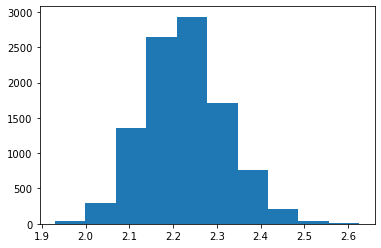

In [33]:
plt.hist(kparsec_trace)
print(np.mean(kparsec_trace))
print(np.std(kparsec_trace))

### new C-band residual plot

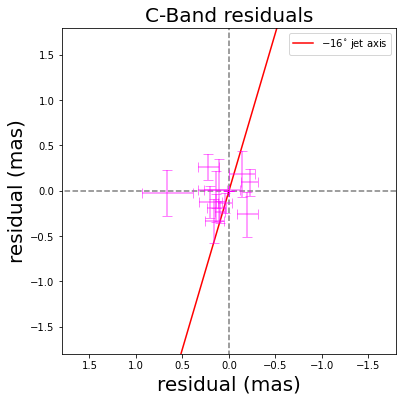

In [34]:
plt.figure(figsize=(6,6))
x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(16 + 90))
plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
plt.title("C-Band residuals",**hfont)
plt.xlabel("residual (mas)",**hfont)
plt.ylabel("residual (mas)",**hfont)
plt.xlim(1.8, -1.8)
plt.ylim(-1.8, 1.8)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             fmt=' ', capsize=5,color="magenta", alpha=0.5)

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('c-bandResiduals.png')

### Calculate BH orbit radius

In [35]:
def getBHorbit(P, M1, M2):
    
    G = 6.6743E-11
    omega = 2*np.pi/(P*60*60)
    a = ((G*M2**3)/(omega**2*(M1+M2)**2))**(1/3)
    return a
    

M0 = 1.989E+30
P = 155.30803 #hrs
dist = 2.39 #kpc
M1 = 9*M0 #solar mass
M2 = 0.067*M1


a = getBHorbit(P, M1, M2)
print('orbit radius {:.2E}m'.format(a))


dist_SI = dist*1000*3.086e+16
#calculate theta based on s=rxtheta
theta = np.degrees(a/dist_SI)*3600*1000
print('theta {:.2E}mas'.format(theta))

orbit radius 1.36E+09m
theta 3.80E-03mas


### Project coreshift into upper limit on jet size (au)

In [36]:
jet_size_trace_sky = []
jet_size_trace_jetdirection = []
parsec2au = 206265

for i in tqdm(range(1000)):
    ra_coreshift = mc_trace_sampler(V404_trace_2DV2['ra shift'])*3.6e6 #mas
    dec_coreshift = mc_trace_sampler(V404_trace_2DV2['dec shift'])*3.6e6 #mas
    
    cs_theta_perp_t, cs_theta_para_t = jet_coordinates(ra_coreshift\
                                             , dec_coreshift, V404_jet_angle)

    
    #total_coreshift = np.sqrt(ra_coreshift**2 + dec_coreshift**2)
    total_coreshift = cs_theta_para_t
    core_shift_radians = np.radians(total_coreshift*1e-3/3600) ## mas to rad
    
    ## get distance to source (in au as final product)
    parallax = mc_trace_sampler(V404_trace_1DV2["parallax"])*1e-3 #asec
    dist_parsec = 1/parallax
    dist_au = dist_parsec*parsec2au
    
    #s=rxtheta
    jet_size_skyplane = dist_au*core_shift_radians #units au
    
    #reproject along the jet
    jet_size_jetdirection = jet_size_skyplane/np.sin(np.radians(67))
    
    jet_size_trace_sky.append(jet_size_skyplane)
    jet_size_trace_jetdirection.append(jet_size_jetdirection)
    

100%|██████████| 1000/1000 [00:00<00:00, 3454.94it/s]


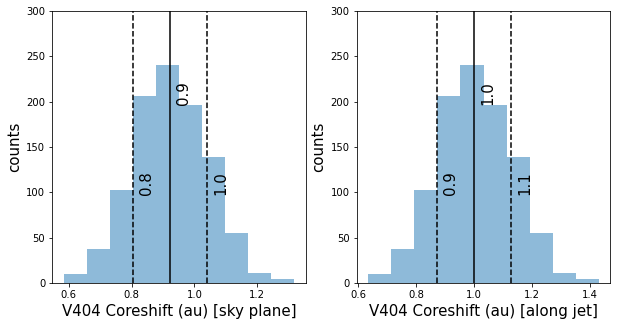

In [37]:
plt.figure(figsize=(10,5))
hfont = {'fontname':'Helvetica', 'size':15}

plt.subplot(121)
plt.hist(jet_size_trace_sky, alpha=0.5)
plt.xlabel('V404 Coreshift (au) [sky plane]', **hfont)
plt.vlines(np.median(jet_size_trace_sky) - np.std(jet_size_trace_sky), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_sky) + np.std(jet_size_trace_sky), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_sky), 0, 550, color='black')
var = np.copy(jet_size_trace_sky)
plt.text(np.median(var)+0.02, 200, round(np.median(var),1), rotation=90, **hfont)
plt.text(np.median(var)+np.std(var)+0.02, 100, round(np.median(var)+np.std(var),1), rotation=90, **hfont)
plt.text(np.median(var)-np.std(var)+0.02, 100, round(np.median(var)-np.std(var),1), rotation=90, **hfont)
plt.ylim(0, 300)
plt.ylabel('counts',**hfont)

plt.subplot(122)
plt.hist(jet_size_trace_jetdirection, alpha=0.5)
plt.xlabel('V404 Coreshift (au) [along jet]', **hfont)
plt.vlines(np.median(jet_size_trace_jetdirection) - np.std(jet_size_trace_jetdirection), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_jetdirection) + np.std(jet_size_trace_jetdirection), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_jetdirection), 0, 550, color='black')
var = np.copy(jet_size_trace_jetdirection)
plt.text(np.median(var)+0.02, 200, round(np.median(var),1), rotation=90, **hfont)
plt.text(np.median(var)+np.std(var)+0.02, 100, round(np.median(var)+np.std(var),1), rotation=90, **hfont)
plt.text(np.median(var)-np.std(var)+0.02, 100, round(np.median(var)-np.std(var),1), rotation=90, **hfont)
plt.ylim(0, 300)
plt.ylabel('counts',**hfont)
plt.savefig('V404JetSize.png')